In [1]:
import argparse
import os
import warnings

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)

from mmdet.apis import multi_gpu_test, single_gpu_test
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
import numpy as np

# class SwinDetector:
#     def __init__(self, config = 'configs/insurance/config_swinT_cascade.py', 
#                        checkpoint = "/media/a4000/Data Center/huyenhc/Swin-Transformer-Object-Detection/work_dirs/work_dirs/config_swinT_cascade/epoch_36.pth"):
#         self.model = init_detector(config, checkpoint, device='cuda:0')
    
#     def __call__(self, img):
#         result = inference_detector(self.model, img)
#         list_result = []
#         for c in range(len(result[0])):
#             if len(result[0][c])!=0:
#                 for i in range(len(result[0][c])):
#                     roi = np.array(result[0][c][i])[:4]
#                     score = result[0][c][i][-1]
#                     mask = np.array(result[1][c][i]).astype(np.int)
#                     list_result.append([mask, roi, c, score])
#         return list_result
    
#     def plot(self, img):
#         result = inference_detector(self.model, img)
#         show_result_pyplot(self.model, img, result, score_thr=0.3)
                            


In [2]:
import argparse
import torch
from mmcv import DictAction
from mmcv.parallel import MMDataParallel

from mmdeploy.apis import build_task_processor
from mmdeploy.utils.config_utils import load_config
from mmdeploy.utils.device import parse_device_id
from mmdeploy.utils.timer import TimeCounter

deploy_cfg_path = "./configs/mmdet/instance-seg/instance-seg_tensorrt-int8_dynamic-320x320-1344x1344.py"
model_cfg_path = "../mmdetection/configs/insurance/cascade_mask_rcnn_restnext101.py"
deploy_cfg, model_cfg = load_config(deploy_cfg_path, model_cfg_path)
task_processor = build_task_processor(model_cfg, deploy_cfg, "cuda:0")

model_file = ['end2end.engine']
model = task_processor.init_backend_model(model_file)

is_device_cpu = False
device_id = None if is_device_cpu else parse_device_id("cuda:0")

# model = MMDataParallel(model, device_ids=[device_id])


2022-06-13 21:50:03,104 - mmdeploy - INFO - Successfully loaded tensorrt plugins from /home/seta2023/huyenhc/MMDeploy/build/lib/libmmdeploy_tensorrt_ops.so
2022-06-13 21:50:03,105 - mmdeploy - INFO - Successfully loaded tensorrt plugins from /home/seta2023/huyenhc/MMDeploy/build/lib/libmmdeploy_tensorrt_ops.so


In [39]:
import cv2
from mmdet.core import get_classes
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter

img = cv2.imread("demo/demo.jpg") 
# result = inference_detector(model, img) 
#inference
imgs = [img]
is_batch = False
cfg = model_cfg
device = torch.device("cuda:0")

if isinstance(imgs[0], np.ndarray):
    cfg = cfg.copy()
    # set loading pipeline type
    cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'
cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
test_pipeline = Compose(cfg.data.test.pipeline)


datas = []
for img in imgs:
    # prepare data
    if isinstance(img, np.ndarray):
        # directly add img
        data = dict(img=img)
    else:
        # add information into dict
        data = dict(img_info=dict(filename=img), img_prefix=None)
    # build the data pipeline
    data = test_pipeline(data)
    datas.append(data)
data = collate(datas, samples_per_gpu=len(imgs))
data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
data['img'] = [img.data[0] for img in data['img']]
data = scatter(data, [device])[0]

import time
start_time = time.time()
with torch.no_grad():
    results = model(return_loss=False, rescale=True, **data)
result = results[0]
print(time.time() - start_time)

0.2507619857788086


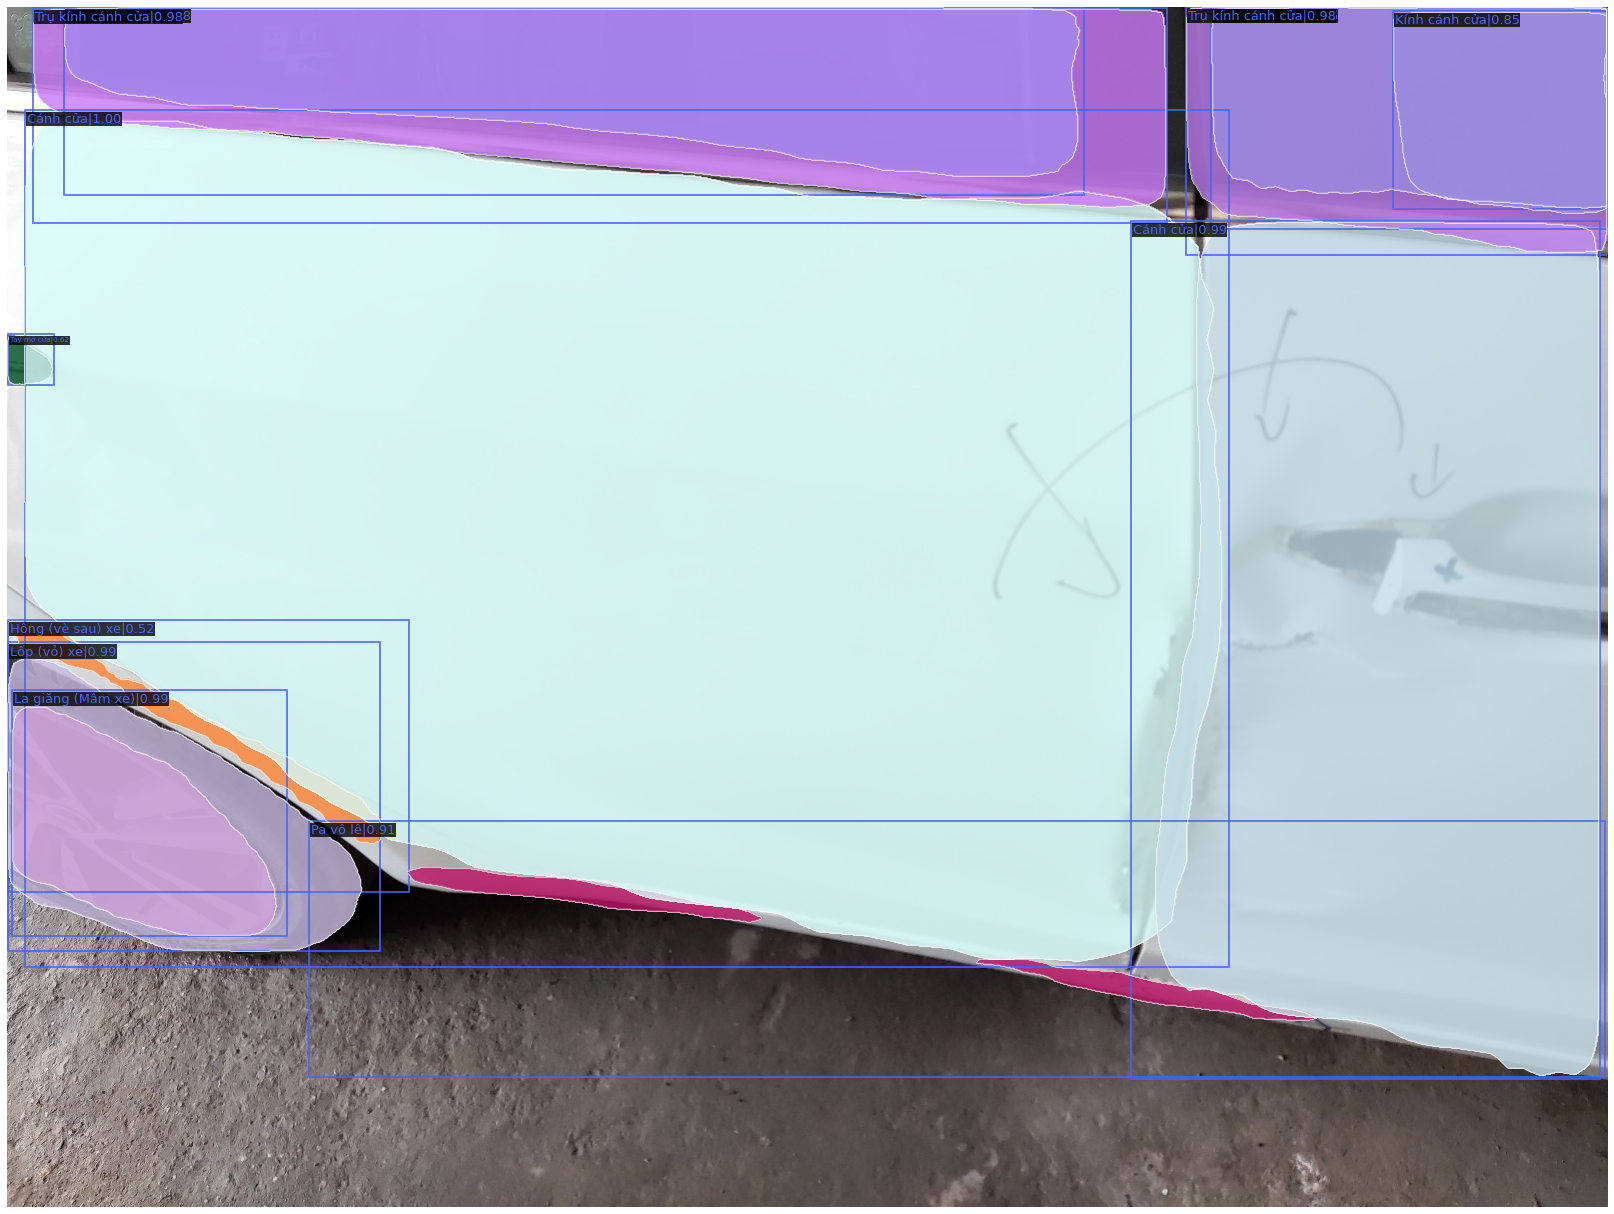

In [41]:
# show_result_pyplot(model, img, result, score_thr=0.3)
model.show_result(img, result, score_thr=0.3)